In [1]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem
from model import NestedUNet
from model import UNet

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import torch

from torchinfo import summary

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# 1. Preparation

## 1.1 DataModule

In [3]:
batch_size = 8
num_workers = 4

In [4]:
road_data = RoadSatelliteModule()

In [5]:
X, y = next(iter(road_data.train_dataloader()))

In [6]:
X.shape

torch.Size([8, 3, 80, 80])

## 1.2 Inspect Data

In [7]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

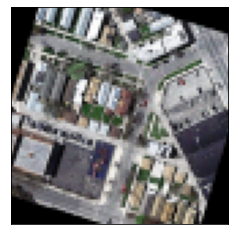

In [8]:
show_image(X[0])

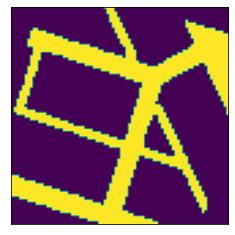

In [9]:
show_image(y[0])

# 2. Define Model / System

In [24]:
model = NestedUNet(1, 3).cuda()

In [25]:
summary(model, input_size=(8, 3, 80, 80))

Layer (type:depth-idx)                             Output Shape              Param #
NestedUNet                                         --                        --
├─VGGBlock: 1-1                                    [8, 16, 80, 80]           --
│    └─Conv2d: 2-1                                 [8, 16, 80, 80]           448
│    └─BatchNorm2d: 2-2                            [8, 16, 80, 80]           32
│    └─ReLU: 2-3                                   [8, 16, 80, 80]           --
│    └─Conv2d: 2-4                                 [8, 16, 80, 80]           2,320
│    └─BatchNorm2d: 2-5                            [8, 16, 80, 80]           32
│    └─ReLU: 2-6                                   [8, 16, 80, 80]           --
├─MaxPool2d: 1-2                                   [8, 16, 40, 40]           --
├─VGGBlock: 1-3                                    [8, 32, 40, 40]           --
│    └─Conv2d: 2-7                                 [8, 32, 40, 40]           4,640
│    └─BatchNorm2d: 2-8     

In [26]:
X, y = next(iter(road_data.train_dataloader()))

In [27]:
X.shape

torch.Size([8, 3, 80, 80])

In [28]:
y_pred = model(X[:2].float().cuda())

In [29]:
y_pred.shape

torch.Size([2, 1, 80, 80])

In [30]:
system = SemanticSegmentationSystem(model, road_data)

# 4. Training

In [31]:
early_stop_callback = EarlyStopping(
   monitor='validation_metric',
   patience=20,
   verbose=2,
   mode='max'
)

In [32]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=-1,
    auto_select_gpus=True,
    #auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [33]:
#trainer.tune(system)

In [34]:
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | NestedUNet | 5.6 M 
1 | dice_loss | DiceLoss   | 0     
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.313    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_metric improved. New best score: 0.693


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.098 >= min_delta = 0.0. New best score: 0.792


Epoch     2: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.015 >= min_delta = 0.0. New best score: 0.807


Epoch     3: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.022 >= min_delta = 0.0. New best score: 0.829


Epoch     4: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Epoch     5: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.014 >= min_delta = 0.0. New best score: 0.844


Epoch     6: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Epoch     7: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.013 >= min_delta = 0.0. New best score: 0.857


Epoch     8: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.857


Epoch     9: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    10: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    11: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    12: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    13: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Epoch    14: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.011 >= min_delta = 0.0. New best score: 0.869


Epoch    15: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Epoch    16: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Epoch    17: adjusting learning rate of group 0 to 7.2727e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.871


Epoch    18: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.015 >= min_delta = 0.0. New best score: 0.885


Epoch    19: adjusting learning rate of group 0 to 5.7864e-04.


Validating: 0it [00:00, ?it/s]

Epoch    20: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Epoch    21: adjusting learning rate of group 0 to 4.2236e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.011 >= min_delta = 0.0. New best score: 0.896


Epoch    22: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Epoch    23: adjusting learning rate of group 0 to 2.7373e-04.


Validating: 0it [00:00, ?it/s]

Epoch    24: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.897


Epoch    25: adjusting learning rate of group 0 to 1.4730e-04.


Validating: 0it [00:00, ?it/s]

Epoch    26: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Epoch    27: adjusting learning rate of group 0 to 5.5442e-05.


Validating: 0it [00:00, ?it/s]

Epoch    28: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    29: adjusting learning rate of group 0 to 7.1497e-06.


Validating: 0it [00:00, ?it/s]

Epoch    30: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    31: adjusting learning rate of group 0 to 9.9846e-04.


Validating: 0it [00:00, ?it/s]

Epoch    32: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    33: adjusting learning rate of group 0 to 9.8620e-04.


Validating: 0it [00:00, ?it/s]

Epoch    34: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    35: adjusting learning rate of group 0 to 9.6198e-04.


Validating: 0it [00:00, ?it/s]

Epoch    36: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Epoch    37: adjusting learning rate of group 0 to 9.2639e-04.


Validating: 0it [00:00, ?it/s]

Epoch    38: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch    39: adjusting learning rate of group 0 to 8.8032e-04.


Validating: 0it [00:00, ?it/s]

Epoch    40: adjusting learning rate of group 0 to 8.5370e-04.


Validating: 0it [00:00, ?it/s]

Epoch    41: adjusting learning rate of group 0 to 8.2490e-04.


Validating: 0it [00:00, ?it/s]

Epoch    42: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Epoch    43: adjusting learning rate of group 0 to 7.6149e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.898


Epoch    44: adjusting learning rate of group 0 to 7.2727e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.905


Epoch    45: adjusting learning rate of group 0 to 6.9165e-04.


Validating: 0it [00:00, ?it/s]

Epoch    46: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.906


Epoch    47: adjusting learning rate of group 0 to 6.1711e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.907


Epoch    48: adjusting learning rate of group 0 to 5.7864e-04.


Validating: 0it [00:00, ?it/s]

Epoch    49: adjusting learning rate of group 0 to 5.3969e-04.


Validating: 0it [00:00, ?it/s]

Epoch    50: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.910


Epoch    51: adjusting learning rate of group 0 to 4.6131e-04.


Validating: 0it [00:00, ?it/s]

Epoch    52: adjusting learning rate of group 0 to 4.2236e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.915


Epoch    53: adjusting learning rate of group 0 to 3.8389e-04.


Validating: 0it [00:00, ?it/s]

Epoch    54: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.000 >= min_delta = 0.0. New best score: 0.915


Epoch    55: adjusting learning rate of group 0 to 3.0935e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.915


Epoch    56: adjusting learning rate of group 0 to 2.7373e-04.


Validating: 0it [00:00, ?it/s]

Epoch    57: adjusting learning rate of group 0 to 2.3951e-04.


Validating: 0it [00:00, ?it/s]

Epoch    58: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Epoch    59: adjusting learning rate of group 0 to 1.7610e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.917


Epoch    60: adjusting learning rate of group 0 to 1.4730e-04.


Validating: 0it [00:00, ?it/s]

Epoch    61: adjusting learning rate of group 0 to 1.2068e-04.


Validating: 0it [00:00, ?it/s]

Epoch    62: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Metric validation_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.918


Epoch    63: adjusting learning rate of group 0 to 7.4606e-05.


Validating: 0it [00:00, ?it/s]

Epoch    64: adjusting learning rate of group 0 to 5.5442e-05.


Validating: 0it [00:00, ?it/s]

Epoch    65: adjusting learning rate of group 0 to 3.9022e-05.


Validating: 0it [00:00, ?it/s]

Epoch    66: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    67: adjusting learning rate of group 0 to 1.4801e-05.


Validating: 0it [00:00, ?it/s]

Epoch    68: adjusting learning rate of group 0 to 7.1497e-06.


Validating: 0it [00:00, ?it/s]

Epoch    69: adjusting learning rate of group 0 to 2.5398e-06.


Validating: 0it [00:00, ?it/s]

Epoch    70: adjusting learning rate of group 0 to 1.0000e-03.


Validating: 0it [00:00, ?it/s]

Epoch    71: adjusting learning rate of group 0 to 9.9961e-04.


Validating: 0it [00:00, ?it/s]

Epoch    72: adjusting learning rate of group 0 to 9.9846e-04.


Validating: 0it [00:00, ?it/s]

Epoch    73: adjusting learning rate of group 0 to 9.9654e-04.


Validating: 0it [00:00, ?it/s]

Epoch    74: adjusting learning rate of group 0 to 9.9385e-04.


Validating: 0it [00:00, ?it/s]

Epoch    75: adjusting learning rate of group 0 to 9.9040e-04.


Validating: 0it [00:00, ?it/s]

Epoch    76: adjusting learning rate of group 0 to 9.8620e-04.


Validating: 0it [00:00, ?it/s]

Epoch    77: adjusting learning rate of group 0 to 9.8125e-04.


Validating: 0it [00:00, ?it/s]

Epoch    78: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch    79: adjusting learning rate of group 0 to 9.6913e-04.


Validating: 0it [00:00, ?it/s]

Epoch    80: adjusting learning rate of group 0 to 9.6198e-04.


Validating: 0it [00:00, ?it/s]

Epoch    81: adjusting learning rate of group 0 to 9.5412e-04.


Validating: 0it [00:00, ?it/s]

Epoch    82: adjusting learning rate of group 0 to 9.4556e-04.


Validating: 0it [00:00, ?it/s]

Monitored metric validation_metric did not improve in the last 20 records. Best score: 0.918. Signaling Trainer to stop.


Epoch    83: adjusting learning rate of group 0 to 9.3631e-04.


In [35]:
model.cuda()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

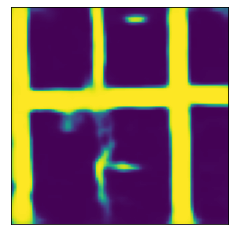

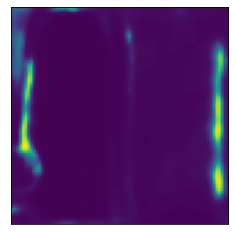

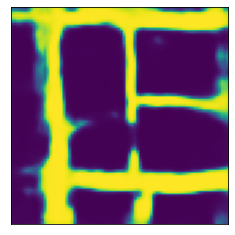

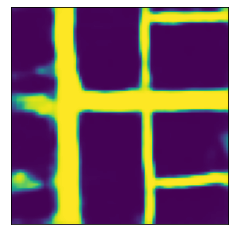

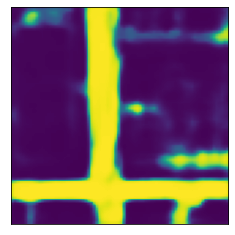

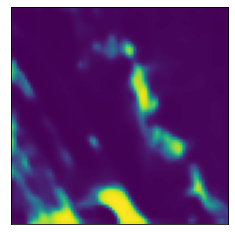

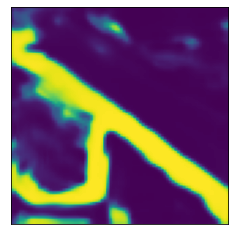

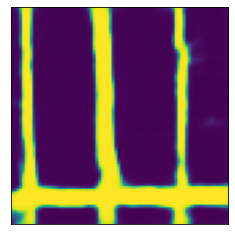

In [36]:
system.visualize_results()

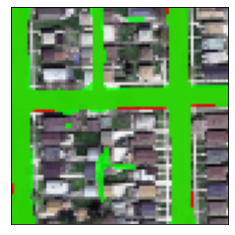

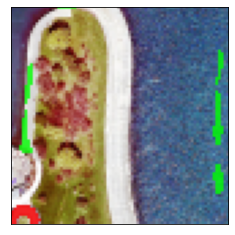

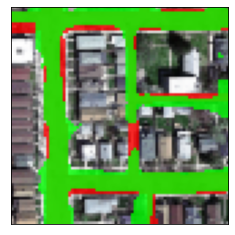

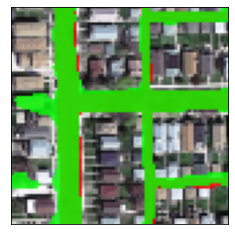

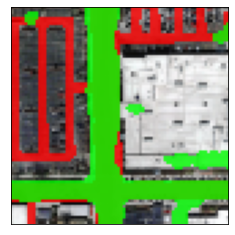

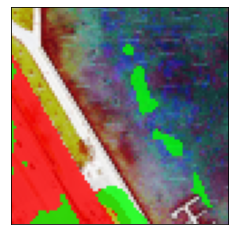

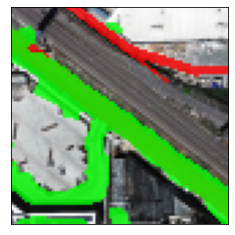

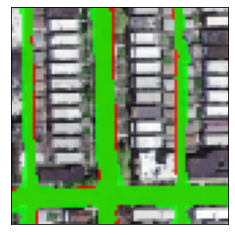

In [37]:
system.visualize_results_overlay()

In [29]:
Xs, ys = next(iter(system.val_dataloader()))

y_preds = torch.sigmoid(model(Xs.float()))

imgs_masks_zip = list(zip(Xs, y))
seg_imgs_masks = [draw_segmentation_masks(train_pair[0], train_pair[1].bool(), colors=['#FF0000']) for train_pair in imgs_masks_zip]

pred_zip = list(zip(seg_imgs_masks, y_preds))
seg_imgs_pred = [draw_segmentation_masks(train_pair[0], train_pair[1].round().bool(), colors=['#00ff00']) for train_pair in pred_zip]

for i, seg_image in enumerate(seg_imgs_pred):
    show_image(seg_image)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument tensors in method wrapper__cat)

In [34]:
model(Xs.float().cuda())

tensor([[[[-8.6295e-02,  8.8783e-03,  1.3704e-01,  ..., -7.8129e-01,
           -4.4170e-01, -4.8561e-01],
          [ 1.3905e-01,  5.1832e-01,  7.1488e-01,  ..., -1.3827e+00,
           -9.0589e-01, -7.3225e-01],
          [ 2.6643e-01,  7.5691e-01,  9.9125e-01,  ..., -1.8888e+00,
           -1.5208e+00, -1.0699e+00],
          ...,
          [ 1.7440e-01,  5.8213e-01,  7.3114e-01,  ..., -1.8758e+00,
           -1.4976e+00, -1.1360e+00],
          [ 6.6367e-02,  3.7241e-01,  5.1199e-01,  ..., -1.7051e+00,
           -1.3988e+00, -1.1055e+00],
          [-9.7150e-02,  9.5649e-02,  1.1033e-01,  ..., -1.6352e+00,
           -1.4036e+00, -1.2472e+00]]],


        [[[-1.1174e-01, -1.0938e-01, -1.0000e-01,  ..., -5.1420e-01,
           -2.2046e-01, -2.9720e-01],
          [-4.8791e-02,  5.0442e-02,  2.2957e-01,  ..., -8.3990e-01,
           -3.4754e-01, -3.8093e-01],
          [ 3.0003e-05,  1.5088e-01,  3.6287e-01,  ..., -1.1449e+00,
           -5.5166e-01, -4.6772e-01],
          ...,
   